In [61]:
from main import main
import matplotlib.pyplot as plt
import numpy as np
import pickle
%matplotlib inline

In [62]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [169]:
seeds = ['0.1', '0.2', '0.5']
metrics_names = ['precision', 'recall', 'f1_score']
metrics = {}
timings = {}

for m in metrics_names:
    metrics[m] = {}
for s in seeds:
    with open("data/pkl/{seed}/precisions.pkl".format(seed=s), "rb") as f:
        metrics['precision'][s] = pickle.load(f)
    with open("data/pkl/{seed}/recalls.pkl".format(seed=s), "rb") as f:
        metrics['recall'][s] = pickle.load(f)
    with open("data/pkl/{seed}/f1_scores.pkl".format(seed=s), "rb") as f:
        metrics['f1_score'][s] = pickle.load(f)
    with open("data/pkl/{seed}/timings.pkl".format(seed=s), "rb") as f:
        timings[s] = pickle.load(f)

In [109]:
def compute_metrics_by_seed(seeds: str, metric: list):
    metric_means = []
    metric_stds = []   
    last_iter = max(metric[0].keys()) + 1
    for i in range(last_iter):
        iter_values = [val[i] for val in metric]
        metric_means.append(np.mean(iter_values))
        metric_stds.append(np.std(iter_values))
    return metric_means, metric_stds

<ipython-input-128-430184d49fba>:15: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


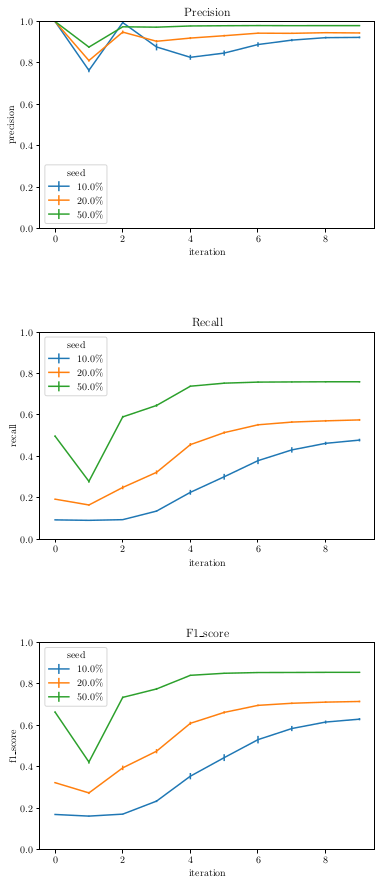

In [128]:
seeds = ['0.1', '0.2', '0.5']
metrics_names = ['precision', 'recall', 'f1_score']
plt.subplots_adjust(left=None, bottom=None, right=None, top=3, wspace=None, hspace=0.5)
for i, metric in enumerate(metrics_names):
    plt.subplot(3, 1, i+1, ymargin=1)
    for s in seeds:
        metric_means, metric_std = compute_metrics_by_seed(s, metrics[metric][s])
        plt.title(metric.capitalize())
        axes = plt.gca()
        axes.set_ylim([0,1])
        plt.xlabel("iteration")
        plt.ylabel(metric)
        plt.errorbar(range(last_iter+1), metric_means, yerr=metric_std, label=str(float(s)*100)+"%")
    plt.legend(title="seed")
    plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc971ab6af0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc971411a00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc9712b6e20>,
 'medians': [<matplotlib.lines.Line2D at 0x7fc9714115e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fc9712e5ee0>,
 'means': []}

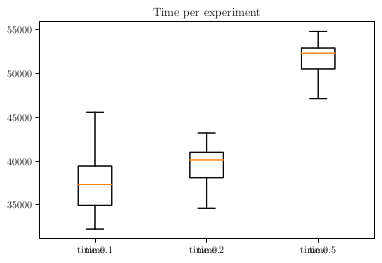

In [151]:
plt.title("Time per experiment")
plt.boxplot([timings['0.1'], timings['0.2'], timings['0.5']], labels=['time 0.1', 'time 0.2', 'time 0.5'])
#plt.boxplot([timings[s] for s in seeds], labels=[s for s in seeds])

In [162]:
def bootstrap_metric(metric_list, n_iter):
    """Compute bootstrap means list to be used for computing confidence intervals
        using bootstrap resample"""
    means = []
    last_iter = max(metric_list[0].keys())
    metric_last = [val[last_iter] for val in metric_list]
    for i in range(n_iter):
        # Bootstrap
        metric_sample = np.random.choice(metric_last, size=len(metric_last), replace=True)
        means.append(np.mean(metric_sample))

    return means

In [163]:
def confidence_interval(means, conf_percent):
    # Computing low quantile (2.5 in our case)
    low_p = ((1.0 - conf_percent) / 2.0) * 100
    lower = np.percentile(means, low_p)

    # Computing high quantile
    high_p = (conf_percent + ((1.0 - conf_percent) / 2.0)) * 100
    upper = np.percentile(means, high_p)

    return [lower, upper]

In [171]:
def plot_confidence(means_metric, interval, index):
    # Computing the mean error
    mean = np.mean(means_metric)
    
    plt.subplots(9, 1, index+1)
    # Plot scores
    plt.hist(means_metric, bins=25)

    # Plot of two interval lines
    plt.axvline(interval[0], color='k', linestyle='dashed', linewidth=1)
    plt.axvline(interval[1], color='k', linestyle='dashed', linewidth=1)
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)

    plt.title("95.0 % confidence interval")
    plt.xlabel("A certain metric mean")
    plt.ylabel("Count")

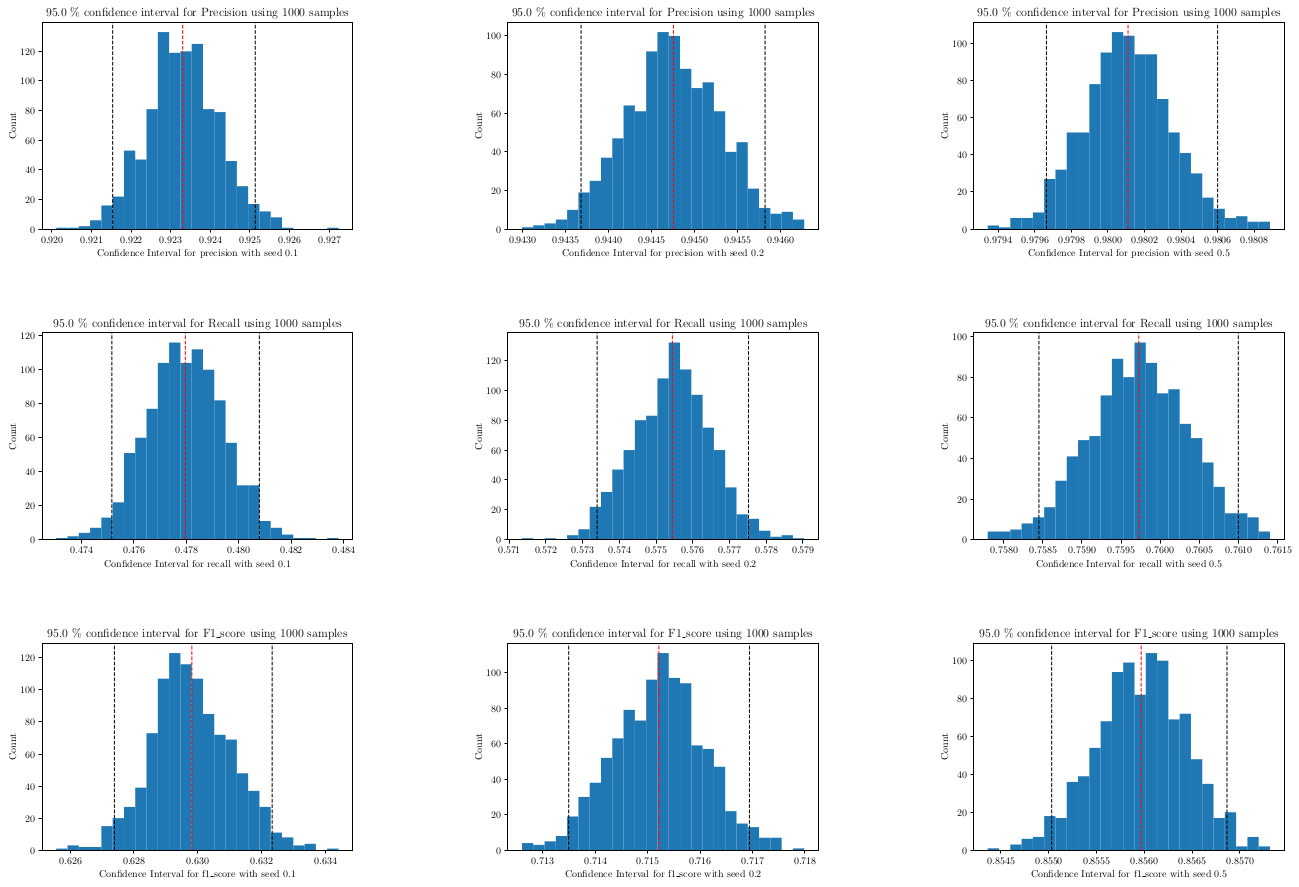

In [184]:
metrics_names = ['precision', 'recall', 'f1_score']
seeds = ['0.1', '0.2', '0.5']
index = 1
plt.subplots_adjust(left=None, bottom=None, right=3, top=3, wspace=0.5, hspace=0.5)

for m in metrics_names:
    for s in seeds:
        means_metric = bootstrap_metric(metrics[m][s], 1000)
        interval = confidence_interval(means_metric, 0.95)
#         plot_confidence(means_precision, interval, index)
        mean = np.mean(means_metric)
    
        plt.subplot(3, 3, index)
        # Plot scores
        plt.hist(means_metric, bins=25)

        # Plot of two interval lines
        plt.axvline(interval[0], color='k', linestyle='dashed', linewidth=1)
        plt.axvline(interval[1], color='k', linestyle='dashed', linewidth=1)
        plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)

        plt.title("95.0 % confidence interval for {metric} using 1000 samples".format(metric=m.capitalize()))
        plt.xlabel("Confidence Interval for {metric} with seed {seed}".format(metric=m, seed=s))
        plt.ylabel("Count")
        index += 1 